# Plots for mutation-transmissibility paper

This notebook generates plots for the paper/ directory.

In [85]:
import re
import math
import pickle
import logging
from collections import Counter, OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyrocov.geo import gisaid_to_jhu_location, parse_date, pd_to_torch, read_csv
from pyrocov import mutrans, pangolin

matplotlib.rcParams['figure.dpi'] = 200
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

## Load data

In [44]:
%%time
dataset = mutrans.load_data()
print(dataset.keys())
locals().update(dataset)

  5634516 Loading data
  5635192 Training on 914312 rows with columns:
  5635193 lineage, virus_name, accession_id, collection_date, location, add_location, day
  5635256 Loaded torch.Size([1245, 13401]) feature matrix
  5643753 WARNING skipping unsampled lineage B.1.1.29
  5644006 Keeping 224/238 regions
  5644131 Keeping 2219/13401 mutations


dict_keys(['location_id', 'mutations', 'weekly_strains', 'features', 'lineage_id', 'lineage_id_inv'])
CPU times: user 9.34 s, sys: 629 ms, total: 9.97 s
Wall time: 9.74 s


## Train via SVI

  1394627 Fitting via SVI
  1394746 Training guide with 283320 parameters:
  1395037 step    0 loss = 26.3109	conc. = 5.26	feat.scale = 0.951
  1406516 step   50 loss = 23.6041	conc. = 9.83	feat.scale = 0.74
  1418095 step  100 loss = 23.1254	conc. = 15	feat.scale = 0.838
  1429470 step  150 loss = 22.9296	conc. = 21.1	feat.scale = 0.877
  1440886 step  200 loss = 22.8282	conc. = 27.3	feat.scale = 0.855
  1452250 step  250 loss = 22.7695	conc. = 30.9	feat.scale = 0.845
  1463759 step  300 loss = 22.7353	conc. = 33.2	feat.scale = 0.866
  1475433 step  350 loss = 22.7085	conc. = 34	feat.scale = 0.83
  1487085 step  400 loss = 22.6895	conc. = 35.5	feat.scale = 0.849
  1498745 step  450 loss = 22.6782	conc. = 35.7	feat.scale = 0.839
  1510411 step  500 loss = 22.6669	conc. = 35.4	feat.scale = 0.839
  1522071 step  550 loss = 22.6582	conc. = 36.9	feat.scale = 0.843
  1533735 step  600 loss = 22.6507	conc. = 36.9	feat.scale = 0.841
  1545300 step  650 loss = 22.6478	conc. = 36.9	feat.scale =

CPU times: user 8min 27s, sys: 44.6 s, total: 9min 11s
Wall time: 3min 52s


Text(0, 0.5, 'loss')

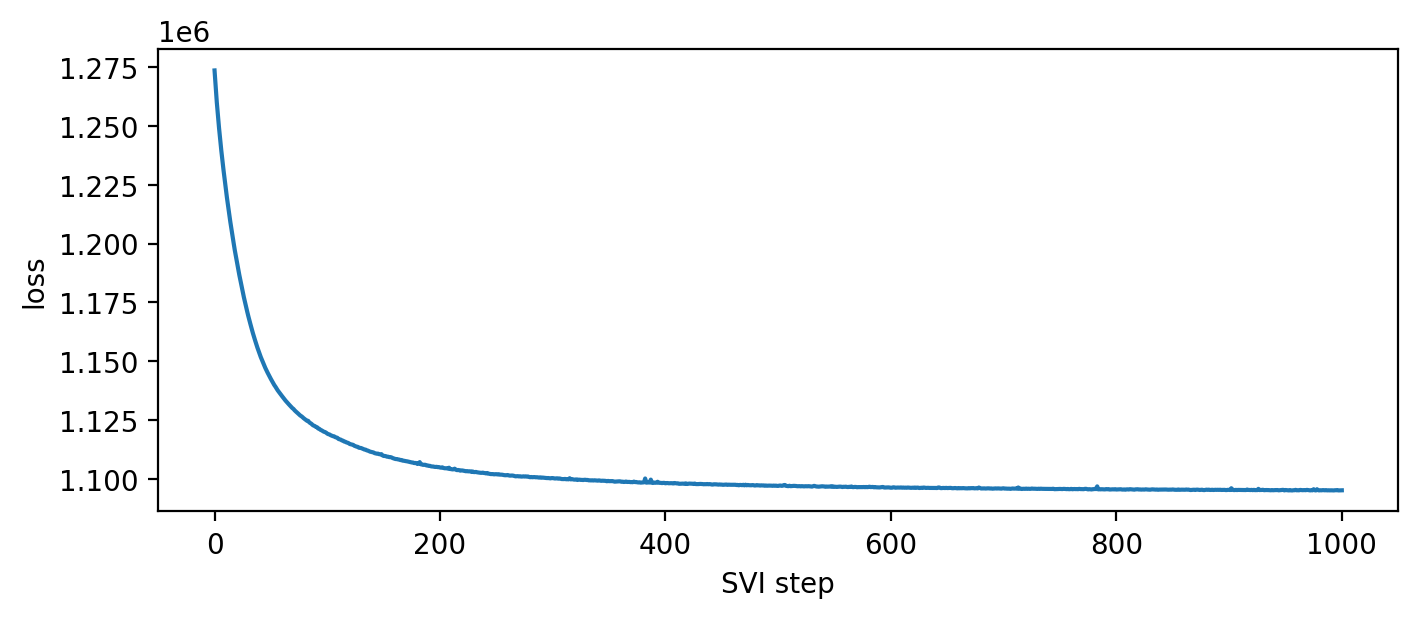

In [7]:
%%time
svi_fit = mutrans.fit_svi(dataset)
plt.figure(figsize=(8, 3))
plt.plot(svi_fit["losses"])
plt.xlabel("SVI step")
plt.ylabel("loss");

In [24]:
svi_fit["median"] = svi_fit["guide"].median()
svi_fit["median"]["log_rate"] = \
    svi_fit["median"]["log_rate_coef"].type_as(features) @ features.T

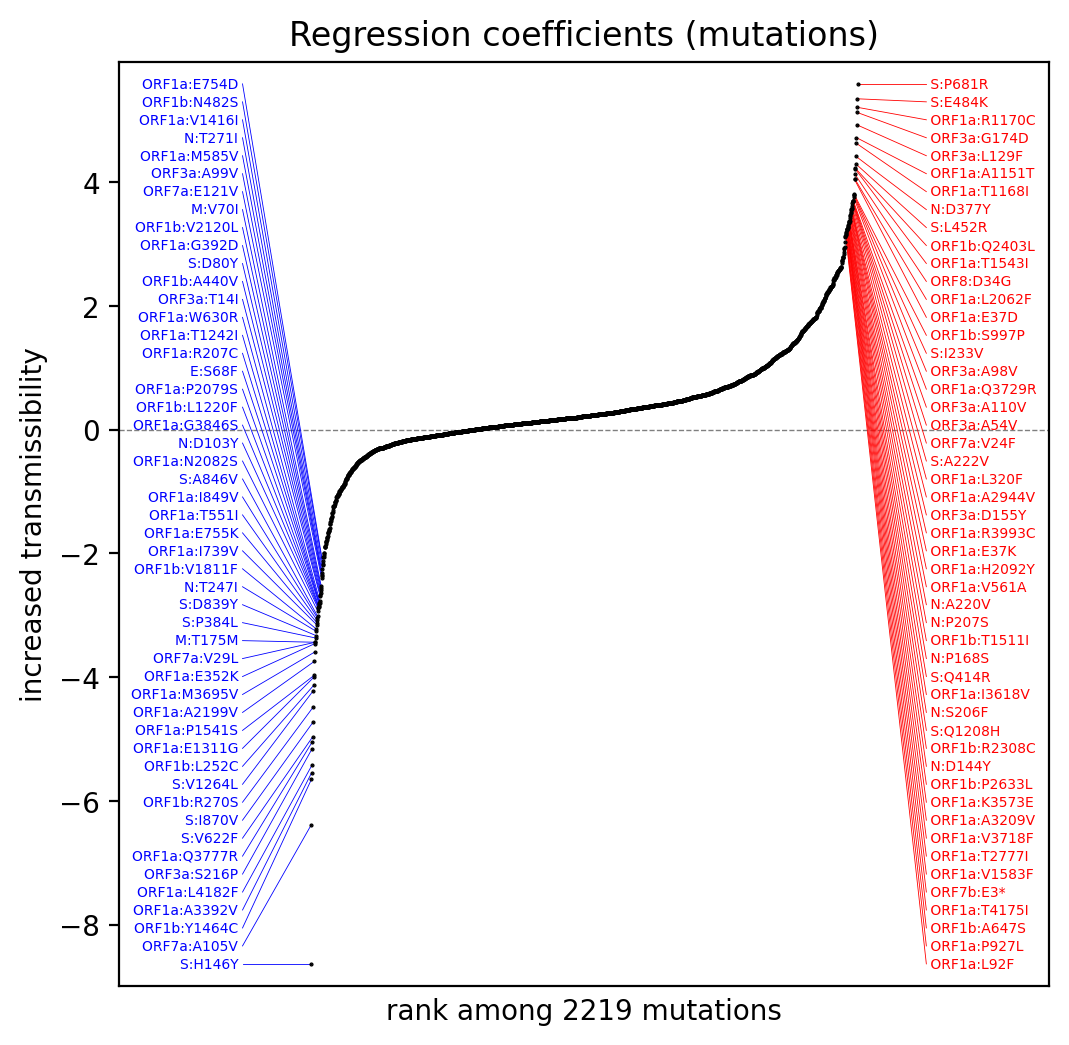

In [19]:
def plot_coefficients(median):
    xs, idx = median["log_rate_coef"].sort(0)
    assert len(idx) == len(mutations)
    plt.figure(figsize=(6, 6))
    plt.title("Regression coefficients (mutations)")
    plt.plot(xs, 'k.', lw=0, markersize=1, zorder=10)
    plt.axhline(0, color='black', lw=0.5, linestyle='--', alpha=0.5)
    plt.xlabel(f"rank among {len(xs)} mutations")
    plt.ylabel("increased transmissibility")

    I = len(idx)
    y0 = float(xs.min())
    y1 = float(xs.max())
    N = 50
    for i in range(N):
        x = -I / 8
        y = y0 + (y1 - y0) * i / (N - 1)
        plt.plot([i, x], [xs[i], y], color='blue', lw=0.3)
        plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(I - N, I):
        x = I + I / 8
        y = y1 + (y0 - y1) * (I - i - 1) / (N - 1)
        plt.plot([i, x], [xs[i], y], color='red', lw=0.3)
        plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.ylim(y0 - (y1 - y0) / 40, y1 + (y1 - y0) / 40)
    plt.xlim(-0.35 * I, 1.35 * I)
    plt.xticks(())

plot_coefficients(svi_fit["median"])

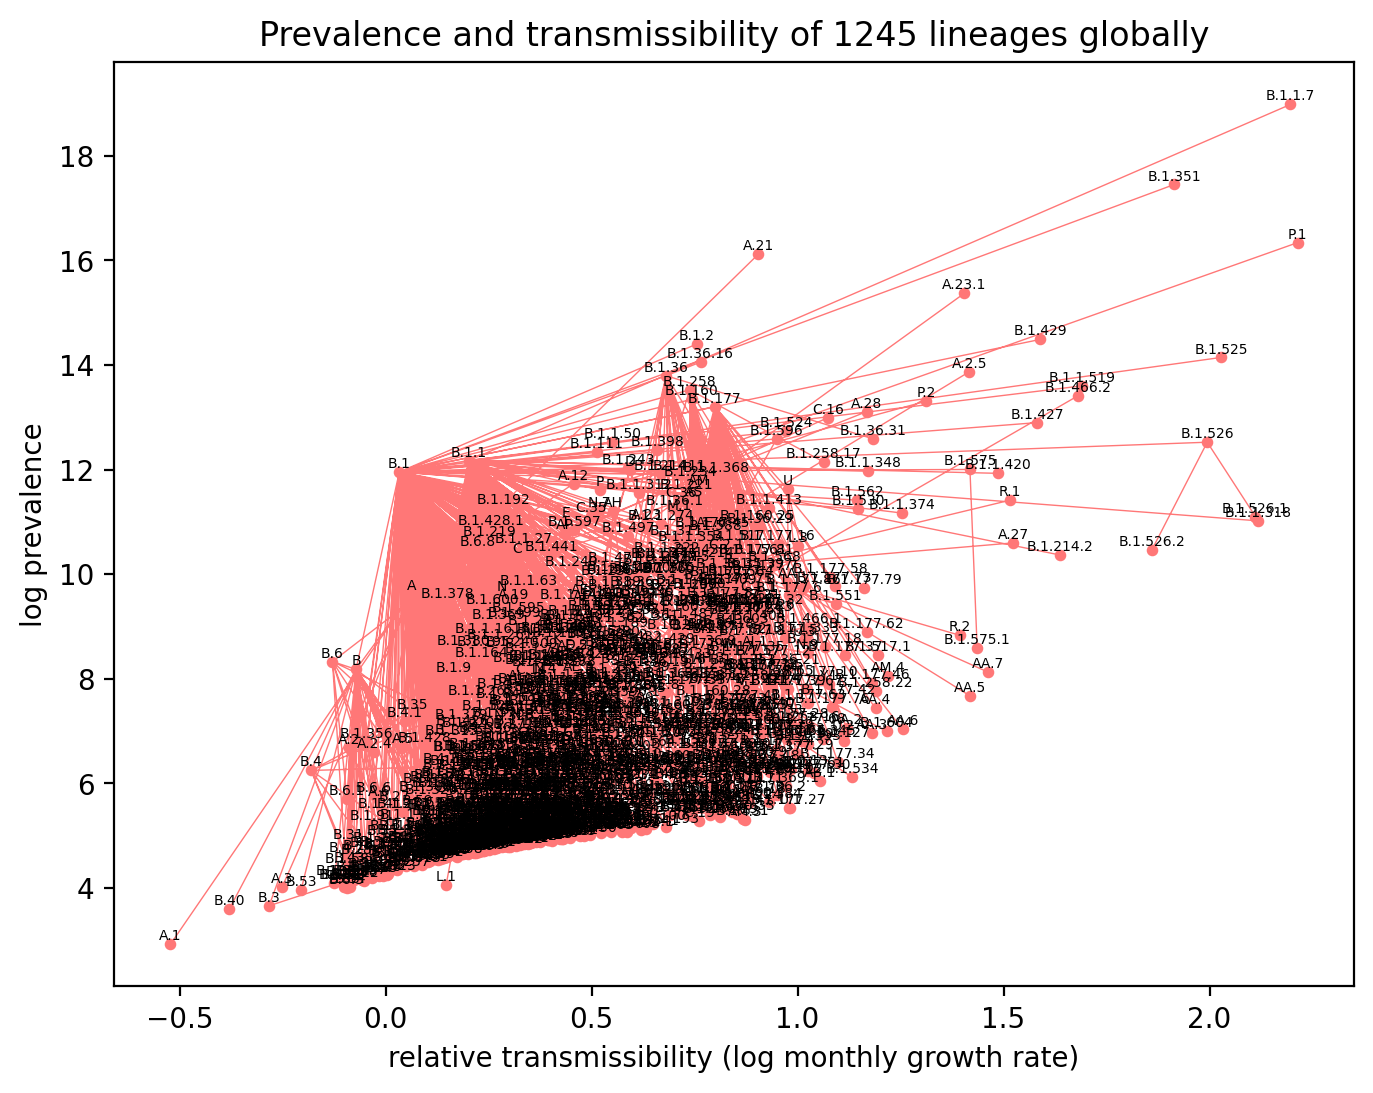

In [26]:
edges = pangolin.find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

def plot_prevalence(median, place_query="", max_len=999):
    ids = [i for name, i in location_id.items() if place_query in name]
    local_lineages = weekly_strains.sum(0)[ids].sum(0).nonzero(as_tuple=True)[0]
    assert ids, "no locations matching " + place_query
    log_rate = median["log_rate"] / 12
    log_init = median["log_init"][ids].logsumexp(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(log_rate[local_lineages], log_init[local_lineages], s=10, color="#ff7777")
    X, Y = [], []
    for u, v in edges.tolist():
        if u in local_lineages and v in local_lineages:
            X.extend([log_rate[u], log_rate[v], None])
            Y.extend([log_init[u], log_init[v], None])
    plt.plot(X, Y, color="#ff7777", lw=0.5)
    for name, i in lineage_id.items():
        if log_init[i] < 0.01:
            continue
        plt.text(log_rate[i], log_init[i] + 0.08, name,
                 fontsize=5, horizontalalignment="center")
    plt.ylabel("log prevalence")
    plt.xlabel("relative transmissibility (log monthly growth rate)")
    plt.title(f"Prevalence and transmissibility of {len(local_lineages)} lineages"
              + (" in " + place_query if place_query else " globally"));
    
plot_prevalence(svi_fit["median"], max_len=7)

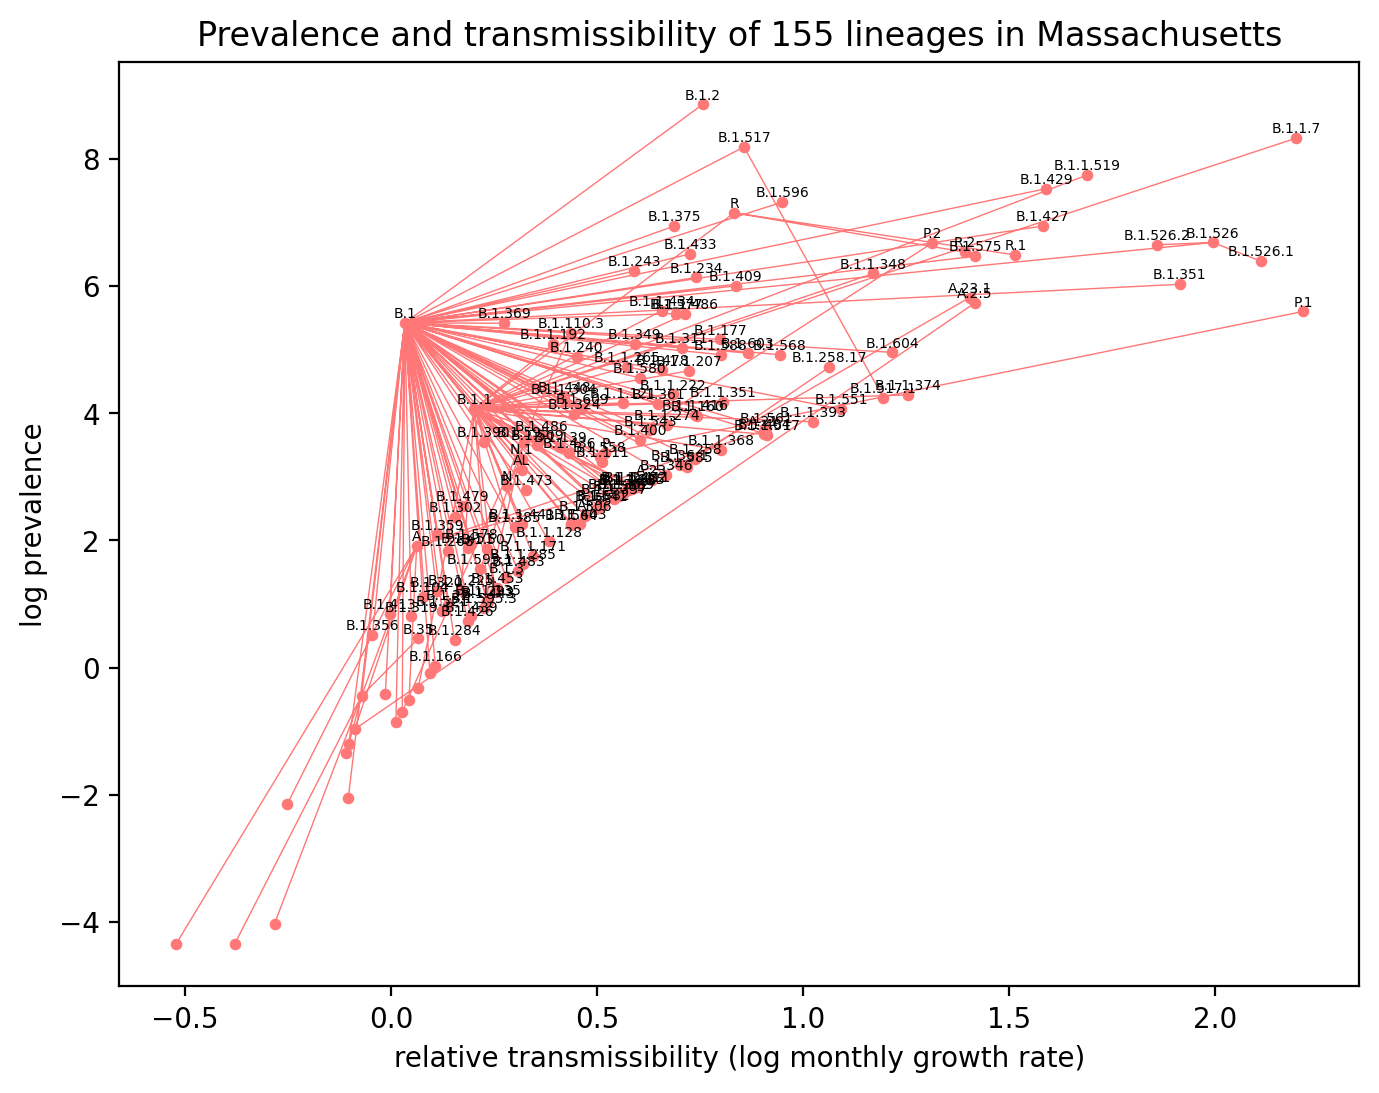

In [29]:
plot_prevalence(svi_fit["median"], place_query="Massachusetts")

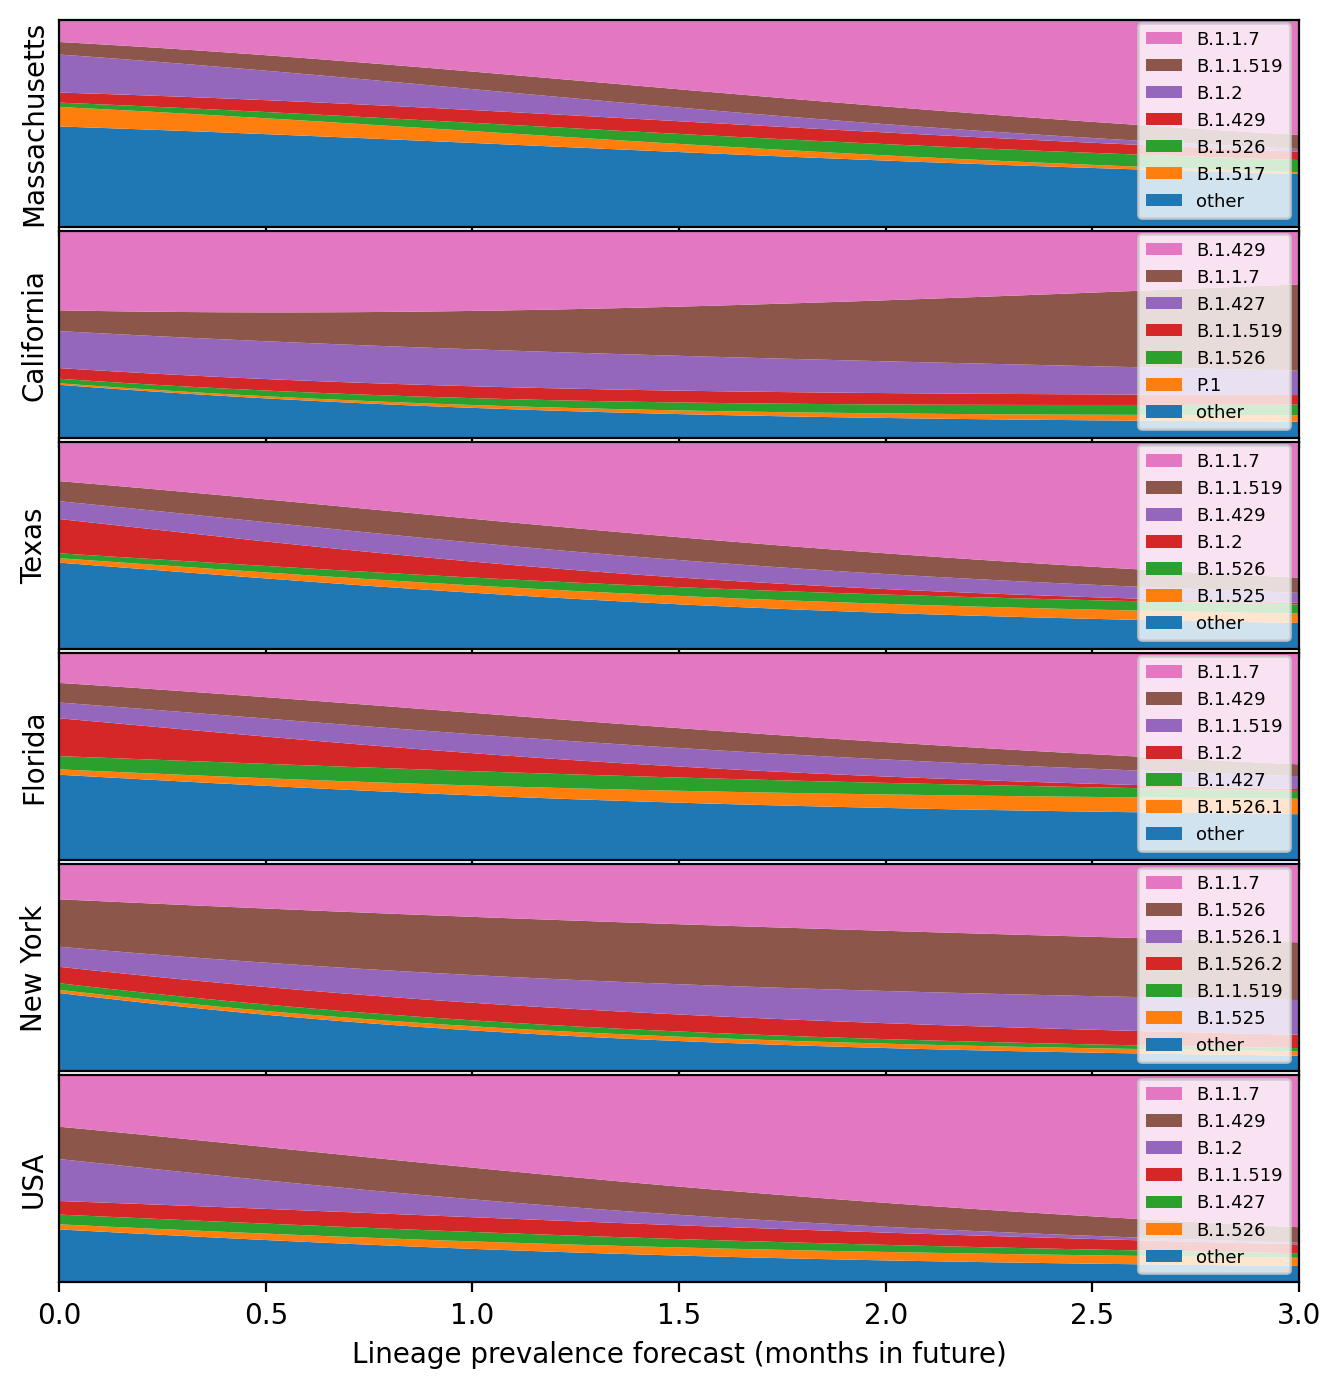

In [31]:
def plot_decomposition(median, queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(svi_fit["median"],
                   ["Mass", "Calif", "Texas", "Florida", "New York", "USA"])

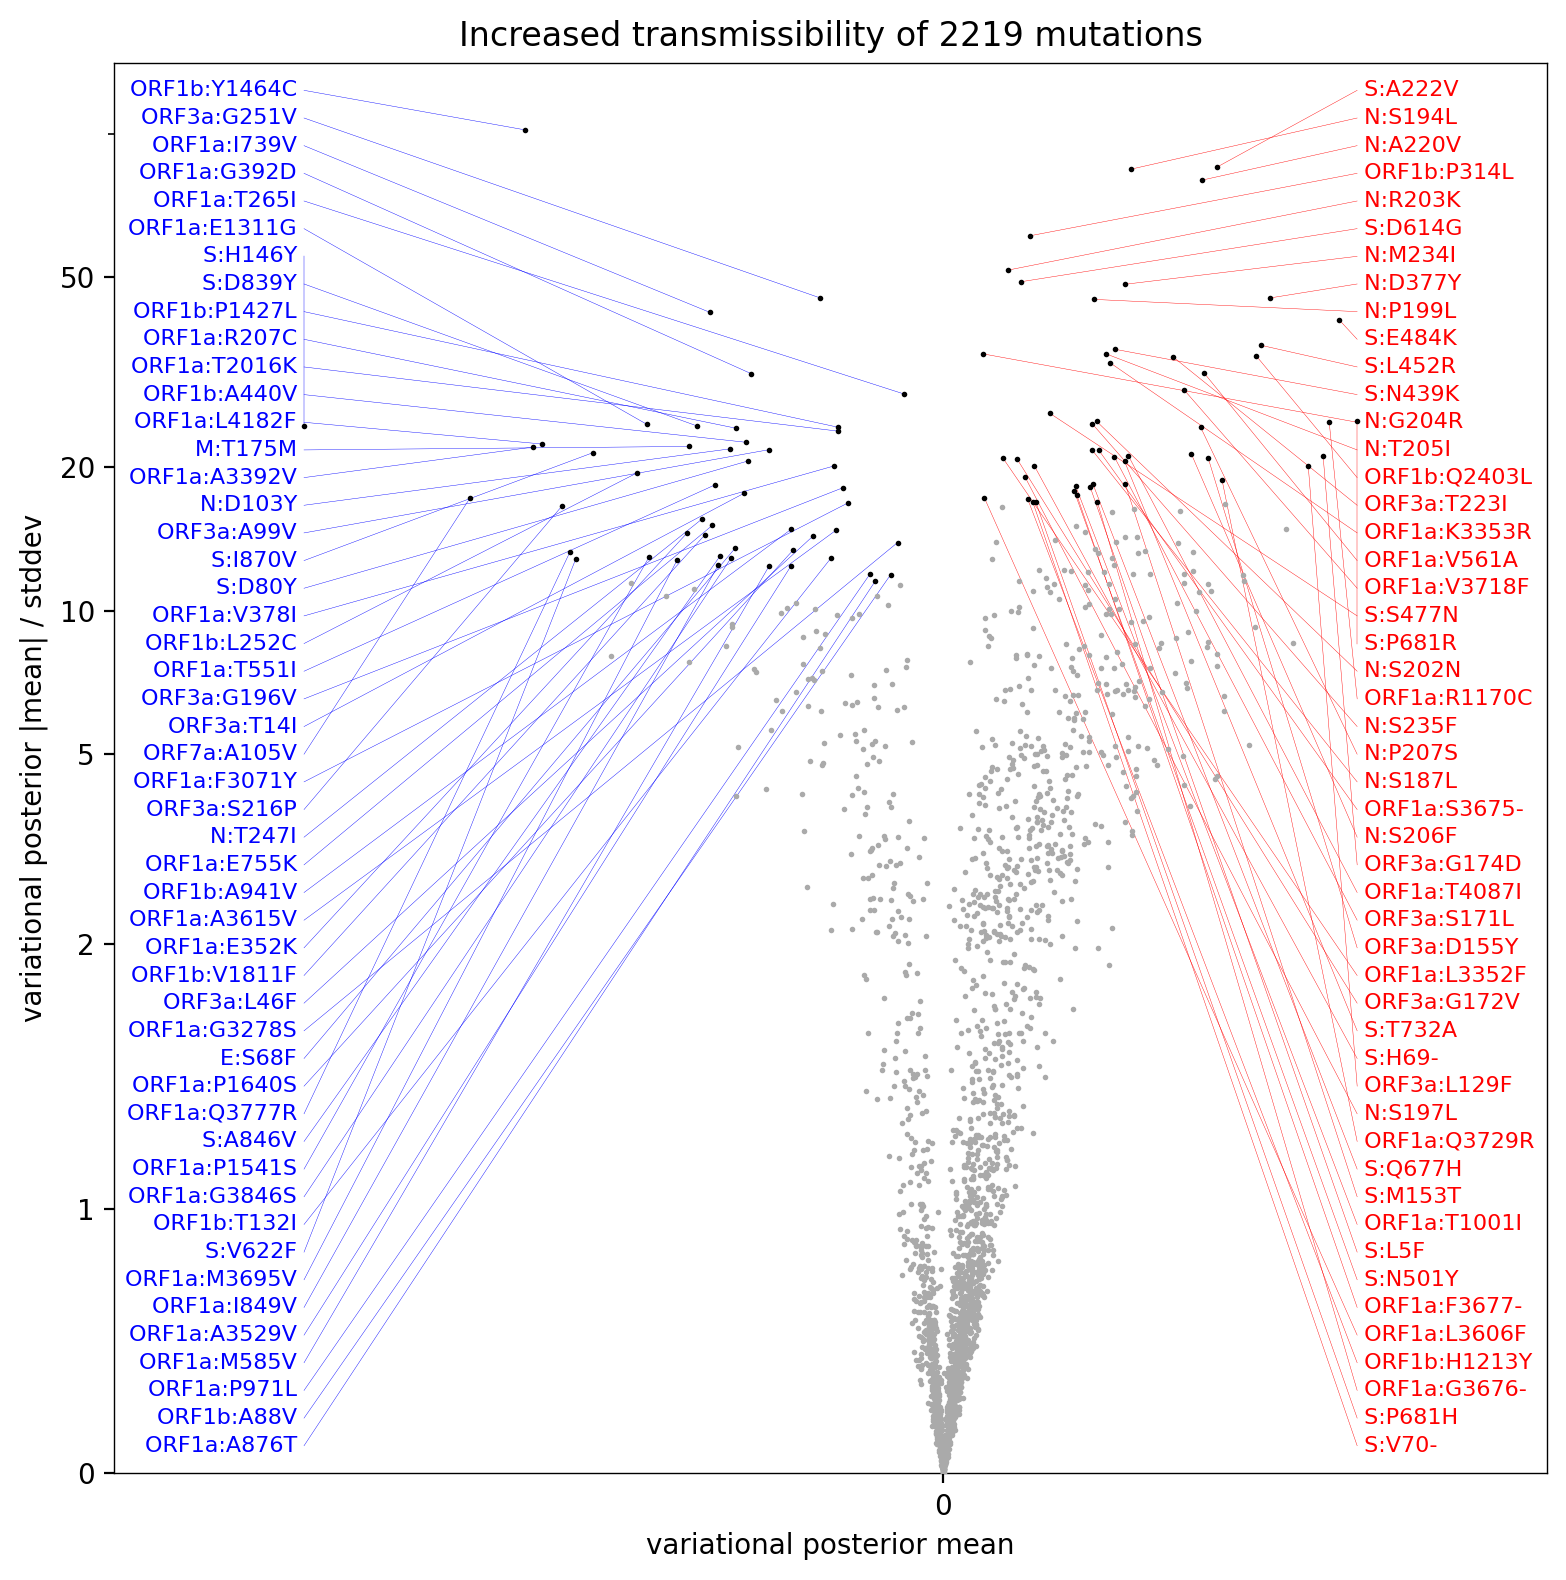

In [35]:
def plot_volcano(mean, std, filenames=()):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = 50

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("variational posterior mean")
    # plt.ylabel("-log10 P(posterior mean has wrong sign)")
    plt.yscale("symlog")
    plt.ylabel("variational posterior |mean| / stddev")
    plt.xlim(x0 - (x1 - x0) * 0.18, x1 + (x1 - x0) * 0.18)
    plt.ylim(0, None)
    # plt.ylim(math.log(2) / math.log(10), None)
    plt.xticks((0,))
    yticks = (0, 1, 2, 5, 10, 20, 50)
    plt.yticks(yticks, list(map(str, yticks)))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='blue', lw=0.15)
        plt.text(x, y, mutations[int(idx_neg[i])] + " ", fontsize=8, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='red', lw=0.15)
        plt.text(x, y, " " + mutations[int(idx_pos[i])], fontsize=8, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(svi_fit["mean"], svi_fit["std"],
             filenames=["paper/volcano.png", "paper/volcano.pdf"])

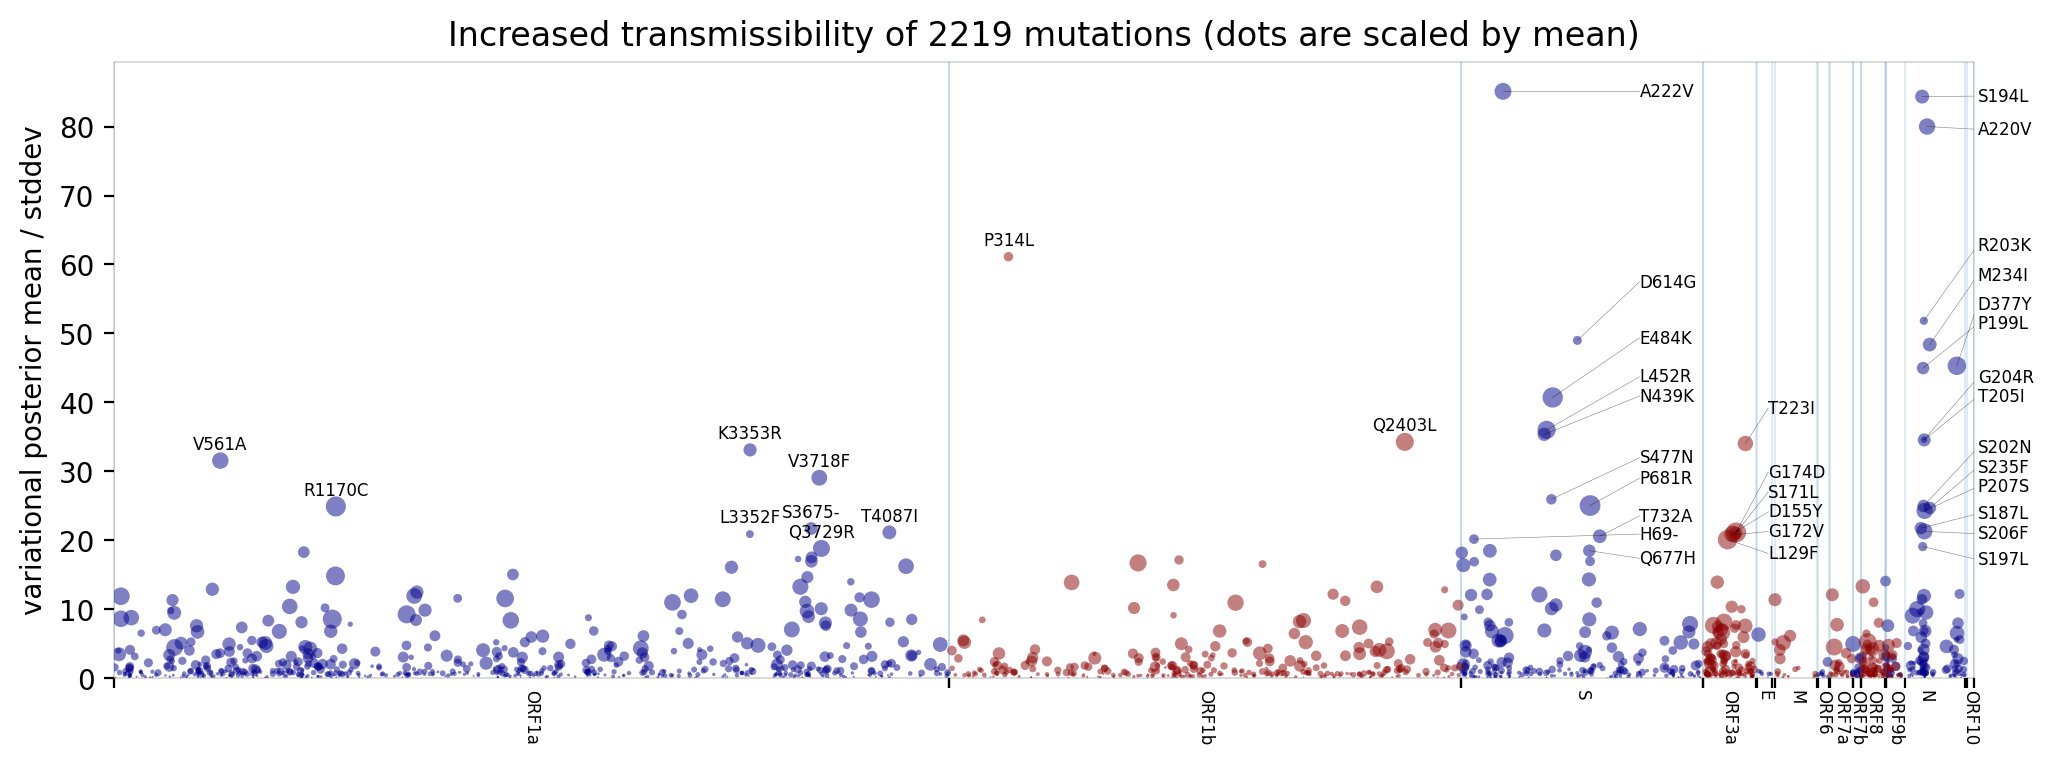

In [37]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=40, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots are scaled by mean)")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 10 * mean[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items()}
    y_bounds = {k: (lb * 0.8, ub * 0.8 + y1 * 0.2) for k, (lb, ub) in y_bounds.items()}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        y_label = 0.7 * y + 0.3 * (ub + (lb - ub) * (i / (len(special["S"]) - 1)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            y_label = 0.5 * y + 0.5 * (ub + (lb - ub) * (i / (len(special[gene]) - 1)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("variational posterior mean / stddev")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(svi_fit["mean"], svi_fit["std"],
               filenames=["paper/manhattan.png", "paper/manhattan.pdf"])

## Extracting a table of top mutations and their stories

In [38]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [39]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [41]:
def write_mutation_table(mean, std, filename="paper/top_mutations.md", top_k=200):
    sigma = mean / std.clamp(min=1e-8)
    lineage_counts = weekly_strains.sum((0, 1))
    with open(filename, "wt") as md, open(filename.replace(".md", ".tsv"), "wt") as tsv:
        md.write("This file was automatically generated by mutation_stochatic_model.ipynb\n")
        md.write("\n")
        md.write("| mutation | mean/stddev | mean | emerged in lineages |\n")
        md.write("| -------- | ----------- | ---- | ------------------- |\n")
        tsv.write("mutation\tmean/stddev\tmean\temerged in lineages\n")
        for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
            emerged = find_emergences(i)
            md.write("| {} | {:0.3g} | {:0.3g} | {} |\n".format(
                mutations[i], sigma[i], mean[i], ", ".join(emerged)
            ))
            tsv.write("{}\t{:0.6g}\t{:0.6g}\t{}\n".format(
                mutations[i], sigma[i], mean[i], ", ".join(emerged)
            ))

write_mutation_table(svi_fit["mean"], svi_fit["std"])

In [43]:
def write_strain_table(mean, filename="paper/top_strains.md", top_k=1000):
    log_rate = mean.type_as(features) @ features.T * (12 / 365.25 * 14)
    num_samples = weekly_strains.sum(0).long()
    global_samples = num_samples.sum(0)
    us_samples = sum(num_samples[i] for name, i in location_id.items() if " USA " in name)
    ma_samples = sum(num_samples[i] for name, i in location_id.items() if " Mass" in name)
    lineages = [None] * len(lineage_id)
    for lineage, i in lineage_id.items():
        lineages[i] = lineage
    with open(filename, "wt") as md, open(filename.replace(".md", ".tsv"), "wt") as tsv:
        md.write("This file was automatically generated by mutation_stochatic_model.ipynb\n")
        md.write("\n")
        md.write("| strain | log growth rate | global samples | US samples | MA samples |\n")
        md.write("| ------ | --------------- | -------------- | ---------- | ---------- |\n")
        tsv.write("rank\tstrain\tlog growth rate\tnumber of samples\n")
        for i in log_rate.sort(0, descending=True).indices[:top_k].tolist():
            emerged = find_emergences(i)
            md.write("| {} | {:0.4g} | {:d} | {:d} | {:d}\n".format(
                lineages[i], log_rate[i], global_samples[i], us_samples[i], ma_samples[i]
            ))
            tsv.write("{}\t{:0.6g}\t{:d}\n".format(
                lineages[i], log_rate[i], global_samples[i], us_samples[i], ma_samples[i]
            ))

write_strain_table(svi_fit["mean"])

## Fit on subsets of data

In [55]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)

In [59]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))

[('hCoV-19/USA/KS-CDC-2-3693594/2020', 1), ('hCoV-19/USA/KS-CDC-2-3693489/2020', 1)]
[('North America / USA / Texas / Houston', 25968), ('North America / USA / California', 10692)]
[('Europe / United Kingdom / England', 263176), ('Europe / United Kingdom / Wales', 31113)]


In [62]:
subsets = {
    ("virus_name_pattern", "^hCoV-19/USA/..-CDC-"): None,
    ("virus_name_pattern", "^hCoV-19/USA/..-CDC-2-"): None,
    ("location_pattern", "^North America / USA"): None,
    ("location_pattern", "^Europe / United Kingdom"): None,
}

In [65]:
%%time
for key, pattern in subsets:
    subset = subsets[key, pattern] = {}
    subset["dataset"] = mutrans.load_data(**{key: pattern})
    subset["svi_fit"] = mutrans.fit_svi(subset["dataset"], log_every=100)

  7621896 Loading data
  7622401 Training on 914312 rows with columns:
  7622402 lineage, virus_name, accession_id, collection_date, location, add_location, day
  7622452 Loaded torch.Size([1245, 13401]) feature matrix
  7629803 WARNING skipping unsampled lineage B.1.1.29
  7629852 Keeping 45912.0/914312 rows
  7629855 Keeping 54/54 regions
  7629963 Keeping 2219/13401 mutations
  7630088 Fitting via SVI
  7630127 Training guide with 71670 parameters:
  7630211 step    0 loss = 40.1205	conc. = 5.26	feat.scale = 0.951
  7635743 step  100 loss = 35.3759	conc. = 29	feat.scale = 0.243
  7641343 step  200 loss = 34.8889	conc. = 160	feat.scale = 0.442
  7646932 step  300 loss = 34.7533	conc. = 233	feat.scale = 0.59
  7652509 step  400 loss = 34.6807	conc. = 253	feat.scale = 0.651
  7658096 step  500 loss = 34.6513	conc. = 267	feat.scale = 0.703
  7663645 step  600 loss = 34.6237	conc. = 287	feat.scale = 0.732
  7669187 step  700 loss = 34.613	conc. = 297	feat.scale = 0.742
  7674806 step  80

CPU times: user 5min 39s, sys: 27.3 s, total: 6min 6s
Wall time: 3min 31s


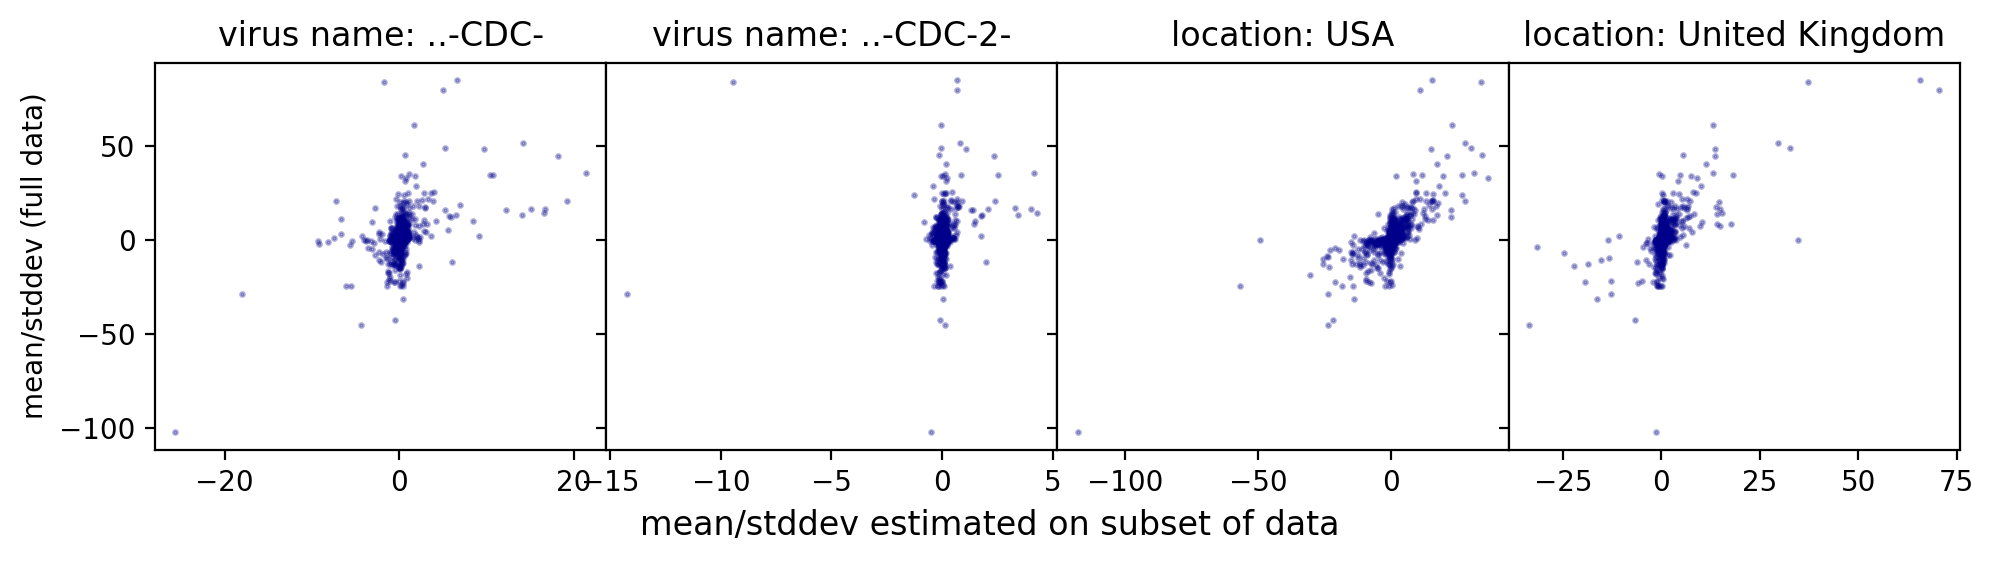

In [110]:
def plot_sigma_agreement():
    mutation_to_id = {m: i for i, m in enumerate(mutations)}
    sigma = svi_fit["mean"] / svi_fit["std"]
    fig, axes = plt.subplots(1, len(subsets), figsize=(10,3), sharey=True)
    for ax, ((key, pattern), subset) in zip(axes, subsets.items()):
        idx = [mutation_to_id[m] for m in subset["dataset"]["mutations"]]
        sigma_subset = subset["svi_fit"]["mean"] / subset["svi_fit"]["std"]
        ax.scatter(sigma_subset.numpy(), sigma[idx].numpy(), 2, color='darkblue', alpha=0.3)
        key = key.replace("_pattern", "").replace("_", " ")
        pattern = re.sub(r"^.*/\s*", "", pattern)
        ax.set_title(f"{key.replace('_pattern', '')}: {pattern}")
    axes[0].set_ylabel("mean/stddev (full data)")
    fig.suptitle("mean/stddev estimated on subset of data", y=0.03)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

plot_sigma_agreement()

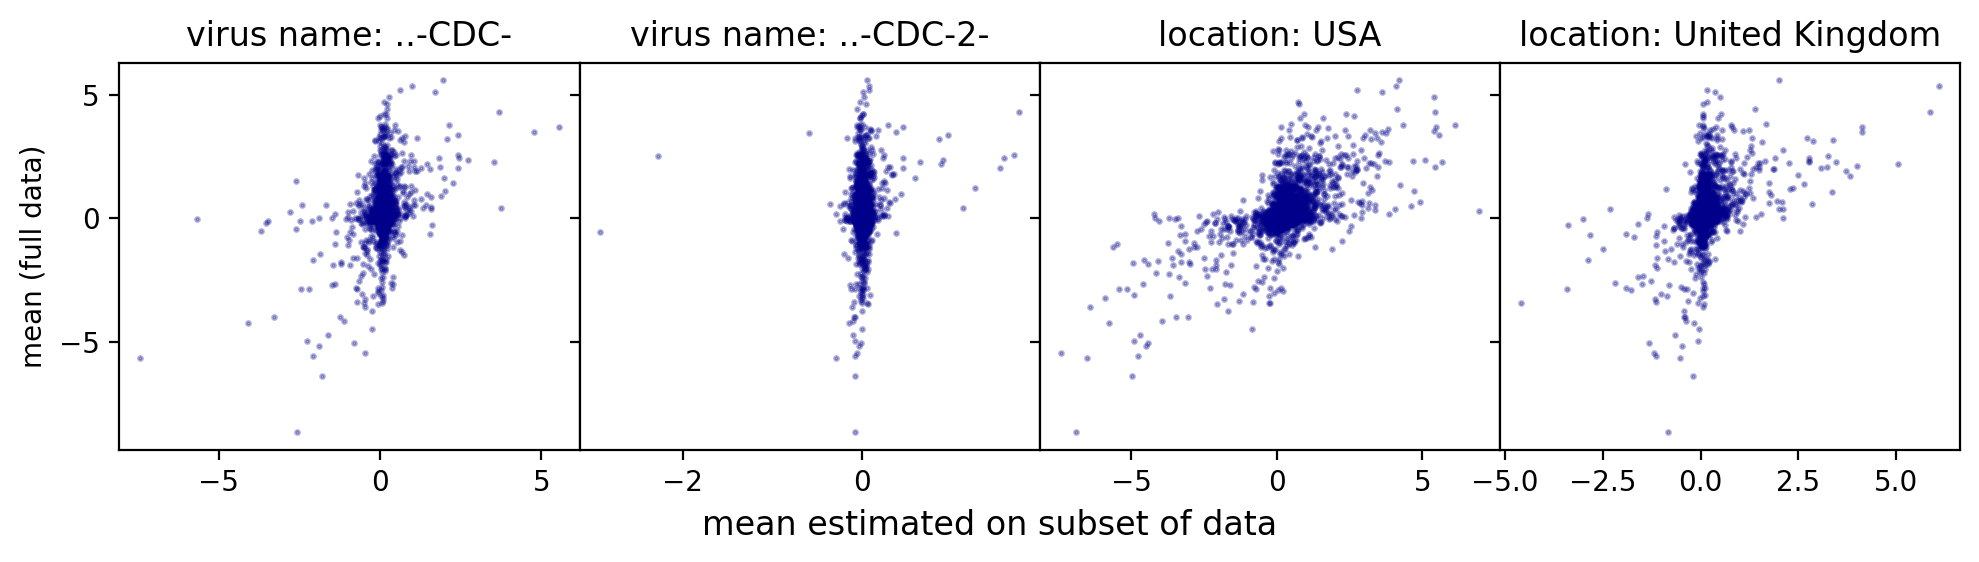

In [109]:
def plot_mean_agreement():
    mutation_to_id = {m: i for i, m in enumerate(mutations)}
    mean = svi_fit["mean"]
    fig, axes = plt.subplots(1, len(subsets), figsize=(10,3), sharey=True)
    for ax, ((key, pattern), subset) in zip(axes, subsets.items()):
        idx = [mutation_to_id[m] for m in subset["dataset"]["mutations"]]
        mean_subset = subset["svi_fit"]["mean"]
        ax.scatter(mean_subset.numpy(), mean[idx].numpy(), 2, color='darkblue', alpha=0.3)
        key = key.replace("_pattern", "").replace("_", " ")
        pattern = re.sub(r"^.*/\s*", "", pattern)
        ax.set_title(f"{key.replace('_pattern', '')}: {pattern}")
    axes[0].set_ylabel("mean (full data)")
    fig.suptitle("mean estimated on subset of data", y=0.03)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

plot_mean_agreement()